# Ride Along with Lucy!

In this notebook we'll examine the trajectory of the Lucy spacecraft itself. We'll look at its complicated orbit and show that we can correcttly predict its encounters. We'll also compute its trajectory after its last scheduled encounter with the equal-mass L5 binary Patroclus/Menoetius on March 3, 2033, and investigate the possibility encountering additional objects.

In [30]:
from spacerocks.spacerock import SpaceRock
from spacerocks.simulation import Simulation
from spacerocks.model import PerturberModel, builtin_models
from spacerocks.units import Units
from spacerocks.spice import SpiceBody, SpiceKernel
from spacerocks.utils import time_handler


import numpy as np
from astropy import units as u
from astropy.time import Time

import matplotlib.pyplot as plt
%matplotlib inline

NASA (and many other space agencies) use a tool called [SPICE](https://naif.jpl.nasa.gov/naif/index.html) to describe the trajectory, maneuvers, and operational parameters of a spacecraft.  Most commonly these are encoded into a file called a SPICE kernel. You can find the one for Lucy [here](https://naif.jpl.nasa.gov/pub/naif/LUCY/kernels/). The set of software tools for working with SPICE files is called the [SPICE toolkit](https://naif.jpl.nasa.gov/naif/toolkit.html). While making full use of its capabilities involve a very non-trivial learning curve (the mastery of which would qualify you to be a NASA flight engineer), `spacerocks` provides us with an interface that's good enough for our purposes while hiding a lot of the details under the hood.

Let's read the Lucy kernel into our software framework.

In [31]:
epoch = time_handler('October 17, 2021').utc.jd # We'll begin the day after Lucy was launched.

kernel = SpiceKernel()
kernel.spk += ["../spice/lcy_211016_330403_230131_OD032-R-TCM08a-P-TCM36-P_v1.bsp"]
kernel.furnsh()

lucy_spice = SpiceBody(spiceid="Lucy", kernel=kernel)

Now we'll build a full-scale model of the solar system including the Lucy targets.

In [32]:
units = Units()
units.timescale = 'tdb' 
units.mass = u.M_sun

spiceids, kernel, _ = builtin_models['HORIZONS']
model = PerturberModel(spiceids=spiceids, kernel=kernel)
sim = Simulation(model=model,  epoch=epoch, units=units)
sim.dt = 1
sim.integrator = 'ias15'


# Add the other Lucy targets
Lucy_targets = ['Eurybates', 'Polymele','Leucus', 'Orus', 'Patroclus']
for target in Lucy_targets:
    rock = SpaceRock.from_horizons(target)    # grab their orbital elements from JPL Horizons
    sim.add_spacerocks(rock)                  # add the to our simulation

In [36]:
# Integrate the system till just past the last encounter (when the current Lucy SPICE kernel ends).
t_start = Time('2023-01-01', format='iso', scale='tdb')
t_end = Time('2033-04-01', format='iso', scale='tdb')
epochs = np.arange(t_start.jd, t_end.jd, 2)

In [37]:
prop, planets, _ = sim.propagate(epochs=epochs, units=units, exact_finish_time=1)

Output()

The integration we just did does not include the Lucy spacecraft itself. That's because Lucy isn't a passive body -- it is engaging in maneuvers throughout the mission duration to optimize the approach to its targets. Fortunately these are precisely what the SPICE kernel is intended to model. In the next cell we use the SPICE kernel we read in above to compute Lucy's position and velocity at each epoch.

In [38]:
lucy_x, lucy_y, lucy_z = np.zeros(len(epochs)), np.zeros(len(epochs)), np.zeros(len(epochs))
lucy_vx, lucy_vy, lucy_vz = np.zeros(len(epochs)), np.zeros(len(epochs)), np.zeros(len(epochs))
for i, epoch in enumerate(epochs):
    try:
        lucy = lucy_spice.at(epoch)
        lucy_x[i]= lucy.x.au
        lucy_y[i] = lucy.y.au
        lucy_z[i] = lucy.z.au
        lucy_vx[i]= lucy.vx[0].value
        lucy_vy[i] = lucy.vy[0].value
        lucy_vz[i] = lucy.vz[0].value
    except:
        t_err = Time(epoch, format='jd', scale='tdb')
        print(f'Spice error at epoch {epoch} = {t_err.iso}')


Spice error at epoch 2460249.5 = 2023-11-01 00:00:00.000
Spice error at epoch 2460251.5 = 2023-11-03 00:00:00.000
Spice error at epoch 2460785.5 = 2025-04-20 00:00:00.000
Spice error at epoch 2461629.5 = 2027-08-12 00:00:00.000
Spice error at epoch 2461631.5 = 2027-08-14 00:00:00.000
Spice error at epoch 2461663.5 = 2027-09-15 00:00:00.000
Spice error at epoch 2461665.5 = 2027-09-17 00:00:00.000
Spice error at epoch 2461879.5 = 2028-04-18 00:00:00.000
Spice error at epoch 2461881.5 = 2028-04-20 00:00:00.000
Spice error at epoch 2462087.5 = 2028-11-12 00:00:00.000


The above procedure produced errors on several specific dates. These are near the dates of specific encounters, and I suspect that the basic SPICE kernel we loaded needs to be supplemented with additional data from some of the many other SPICE kernels available for Lucy.  Until I figure out how to do that, we'll simply ignore those errors and focus on the rest of the trajectory.

In [41]:
print(f"Last time computed: {Time(epoch, format='jd', scale='tdb').iso}")
lucy_spacerock = lucy_spice.at(epoch)   # save the state of Lucy at the final epoch above

Last time computed: 2033-03-31 00:00:00.000


In [42]:
jup = planets[planets.name=="Jupiter Barycenter"]

In [43]:
#get x, y positions in Jupiter's co-rotating frame 
jup_angle = jup.true_longitude 
rot = jup_angle - jup_angle[0] # Jupiter rotates through this angle for each step

x_jup = jup.x.au * np.cos(-rot) - jup.y.au * np.sin(-rot)
y_jup = jup.x.au * np.sin(-rot) + jup.y.au * np.cos(-rot)
x_lucy = lucy_x * np.cos(-rot) - lucy_y * np.sin(-rot)
y_lucy = lucy_x * np.sin(-rot) + lucy_y * np.cos(-rot)

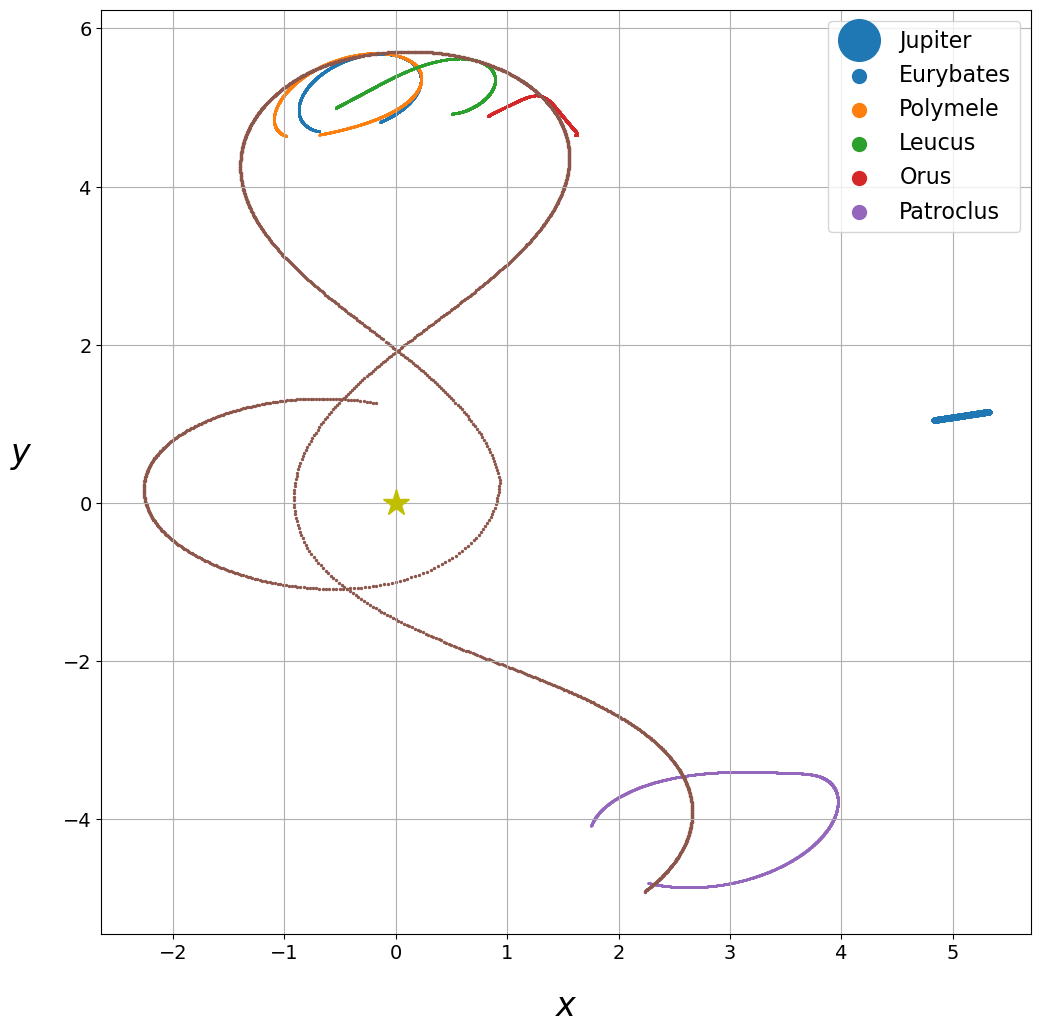

In [44]:
# Plot postions in Jupiter's co-rotating frame
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(0, 0, '*', markersize=20, color='y',)
ax.plot(x_jup, y_jup, '.', label ='Jupiter')
for target in Lucy_targets:
    ast = prop[prop.name==target]
    x_ast = ast.x.au * np.cos(-rot) - ast.y.au * np.sin(-rot)
    y_ast = ast.x.au * np.sin(-rot) + ast.y.au * np.cos(-rot)
    ax.scatter(x_ast, y_ast, s=1, label=ast.name[0])
ax.scatter(x_lucy, y_lucy, s=2)
ax.legend(fontsize=16, markerscale=10)
#ax.legend(fontsize=24)
ax.tick_params(labelsize=14)
ax.set_xlabel(r'$x$', fontsize=24, labelpad=20)
ax.set_ylabel(r'$y$', fontsize=24, labelpad=30, rotation=0)
ax.grid()
plt.savefig('Lucy-corotating.png')

In [51]:
lucy_epoch = Time(epochs[-1], format='jd', scale='tdb')
lucy_epoch.iso,lucy_spacerock.e[-1], lucy_spacerock.a.au[-1], lucy_spacerock.inc.deg[-1]

('2033-03-31 00:00:00.000',
 0.7120289050329988,
 3.289925112530221,
 10.74591803392809)

In [18]:
# What happens after the last encounter?
t_extended_start = Time('2033-04-01', format='iso', scale='tdb')
t_extended_end = Time('2153-04-01', format='iso', scale='tdb')
extended_epochs = np.arange(t_extended_start.jd, t_extended_end.jd, 5)

In [19]:
units = Units()
units.timescale = 'tdb' 
units.mass = u.M_sun

spiceids, kernel, _ = builtin_models['HORIZONS']
model = PerturberModel(spiceids=spiceids, kernel=kernel)
sim = Simulation(model=model,  epoch=epoch, units=units)
sim.dt = 1
sim.integrator = 'ias15'

sim.add_spacerocks(lucy_spacerock)

# Add the other Lucy targets
Lucy_targets = ['Eurybates', 'Polymele','Leucus', 'Orus', 'Patroclus']
for target in Lucy_targets:
    rock = SpaceRock.from_horizons(target)
    sim.add_spacerocks(rock)

/Users/gerdes/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [20]:
prop, planets, _ = sim.propagate(epochs=extended_epochs, units=units, exact_finish_time=1)

Output()

In [21]:
lucy = prop[prop.name=="Lucy"]

In [22]:
lucy.epoch[-1].iso

'2153-03-28 00:00:00.000'

In [23]:
#get x, y positions in Jupiter's co-rotating frame 
jup = planets[planets.name=="Jupiter Barycenter"]

jup_angle = jup.true_longitude 
rot = jup_angle - jup_angle[0] # Jupiter rotates through this angle for each step 
x_jup = jup.x.au * np.cos(-rot) - jup.y.au * np.sin(-rot)
y_jup = jup.x.au * np.sin(-rot) + jup.y.au * np.cos(-rot)
x_lucy = lucy.x.au * np.cos(-rot) - lucy.y.au * np.sin(-rot)
y_lucy = lucy.x.au * np.sin(-rot) + lucy.y.au * np.cos(-rot)



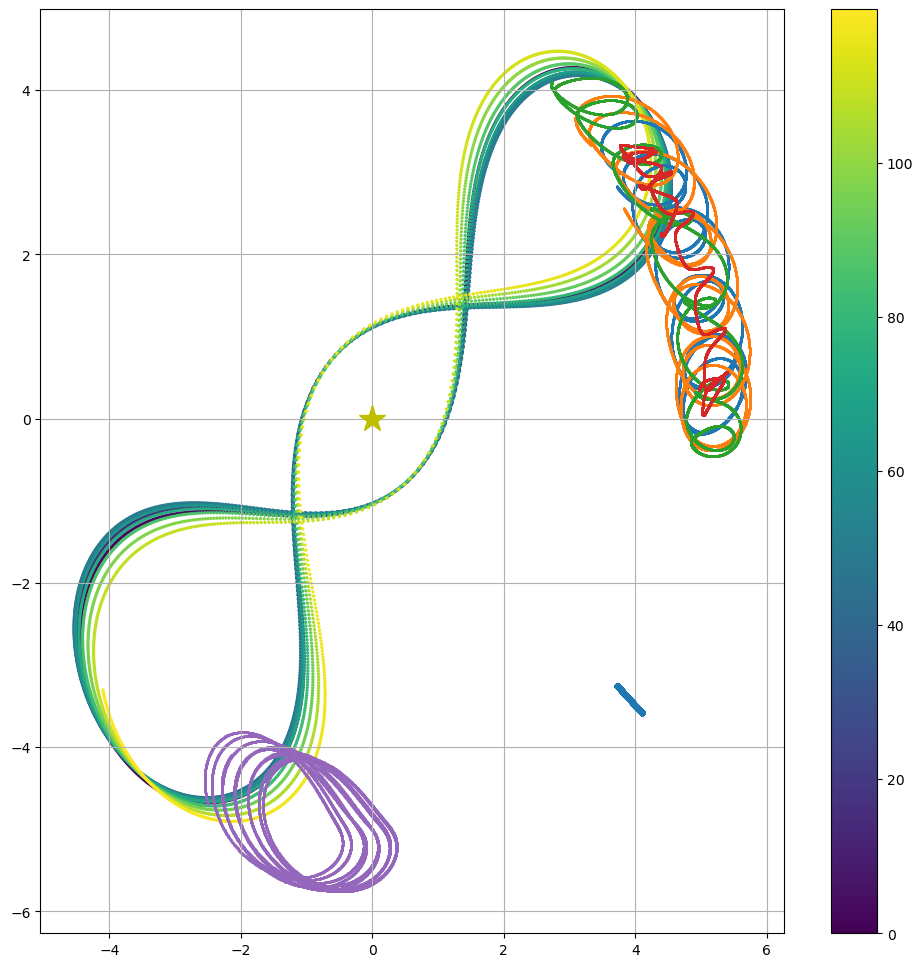

In [24]:
# Plot postions in Jupiter's co-rotating frame
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(0, 0, '*', markersize=20, color='y',)
ax.plot(x_jup, y_jup, '.', label ='Jupiter')
sc = ax.scatter(x_lucy, y_lucy, s=2, c=(lucy.epoch.mjd-lucy.epoch.mjd[0])/365.25)
for target in Lucy_targets:
    ast = prop[prop.name==target]
    x_ast = ast.x.au * np.cos(-rot) - ast.y.au * np.sin(-rot)
    y_ast = ast.x.au * np.sin(-rot) + ast.y.au * np.cos(-rot)
    ax.scatter(x_ast, y_ast, s=1, label=ast.name[0])
ax.grid()
plt.savefig('Lucy_extended.png')
plt.colorbar(sc)

In [25]:
lucy.epoch[-1].iso

'2153-03-28 00:00:00.000'